In [116]:
#packages needed for code
import tarfile
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import scipy.io
import matplotlib.pyplot as plt
import scipy as sp
import scipy.ndimage as spi
import skimage.transform
import xml.etree.ElementTree
import random
random.seed(112358)

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
from keras import regularizers
from sklearn.utils import shuffle
from keras.preprocessing import image
from sklearn.preprocessing import OneHotEncoder


import keras 
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Reshape
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Dropout


%matplotlib inline

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

%matplotlib inline

In [2]:
#set working directory
os.chdir("C:\\Users\\nrunt\\Desktop\\Harvard")

In [3]:
#extract the 3 .mat files from the tar file:lists.tar
tar_list = tarfile.open('lists.tar')

file_list_tar = tar_list.extractfile(tar_list.getmembers()[0])
file_list = scipy.io.loadmat(file_list_tar)

train_list_tar = tar_list.extractfile(tar_list.getmembers()[1])
train_list = scipy.io.loadmat(train_list_tar)

test_list_tar = tar_list.extractfile(tar_list.getmembers()[2])
test_list = scipy.io.loadmat(test_list_tar)

tar_list.close()

In [4]:
#loop through the 3 lists to identify all of the files included, the training files, and test files
file_list_name = []
file_list_name_train = []
file_list_name_test = []

for i in file_list['file_list']:
    file_list_name.append(i[0][0])
    
for i in train_list['file_list']:
    file_list_name_train.append(i[0][0])
    
for i in test_list['file_list']:
    file_list_name_test.append(i[0][0])

In [5]:
#set the title and label sizes
title_fs = 20
label_fs = 16

In [6]:
#create a count of the number of samples for each breed and the number of images in the training/test sets for each breed
#include training percent stats 
br = []
for i in file_list_name:
    br.append(i.split('-')[1].split('/')[0].lower())
    
br_df = pd.DataFrame({'breed':br,'count':1})
br_df = pd.DataFrame(br_df.groupby('breed').sum())

br_trn = []
for i in file_list_name_train:
    br_trn.append(i.split('-')[1].split('/')[0].lower())

br_trn_df = pd.DataFrame({'breed':br_trn,'train_count':1})
br_trn_df = pd.DataFrame(br_trn_df.groupby('breed').sum())
    
br_tst = []
for i in file_list_name_test:
    br_tst.append(i.split('-')[1].split('/')[0].lower())

br_tst_df = pd.DataFrame({'breed':br_tst,'test_count':1})
br_tst_df = pd.DataFrame(br_tst_df.groupby('breed').sum())

br_df = br_df.join(br_trn_df)
br_df = br_df.join(br_tst_df)
br_df['train_pct'] = br_df['train_count']/br_df['count']
br_df['test_pct'] = br_df['test_count']/br_df['count']

print('The min training percent is {:.3f} or {:.0f}/{:.0f}'.format(np.min(br_df['train_pct']),np.max(br_df['train_count']),np.max(br_df['count'])))
print('The max training percent is {:.3f} or {:.0f}/{:.0f}'.format(np.max(br_df['train_pct']),np.min(br_df['train_count']),np.min(br_df['count'])))
print('The mean training percent is {:.3f}'.format(np.mean(br_df['train_pct'])))
print('The mean training percent is {:.3f}'.format(np.median(br_df['train_pct'])))

The min training percent is 0.397 or 100/252
The max training percent is 0.676 or 100/148
The mean training percent is 0.593
The mean training percent is 0.627


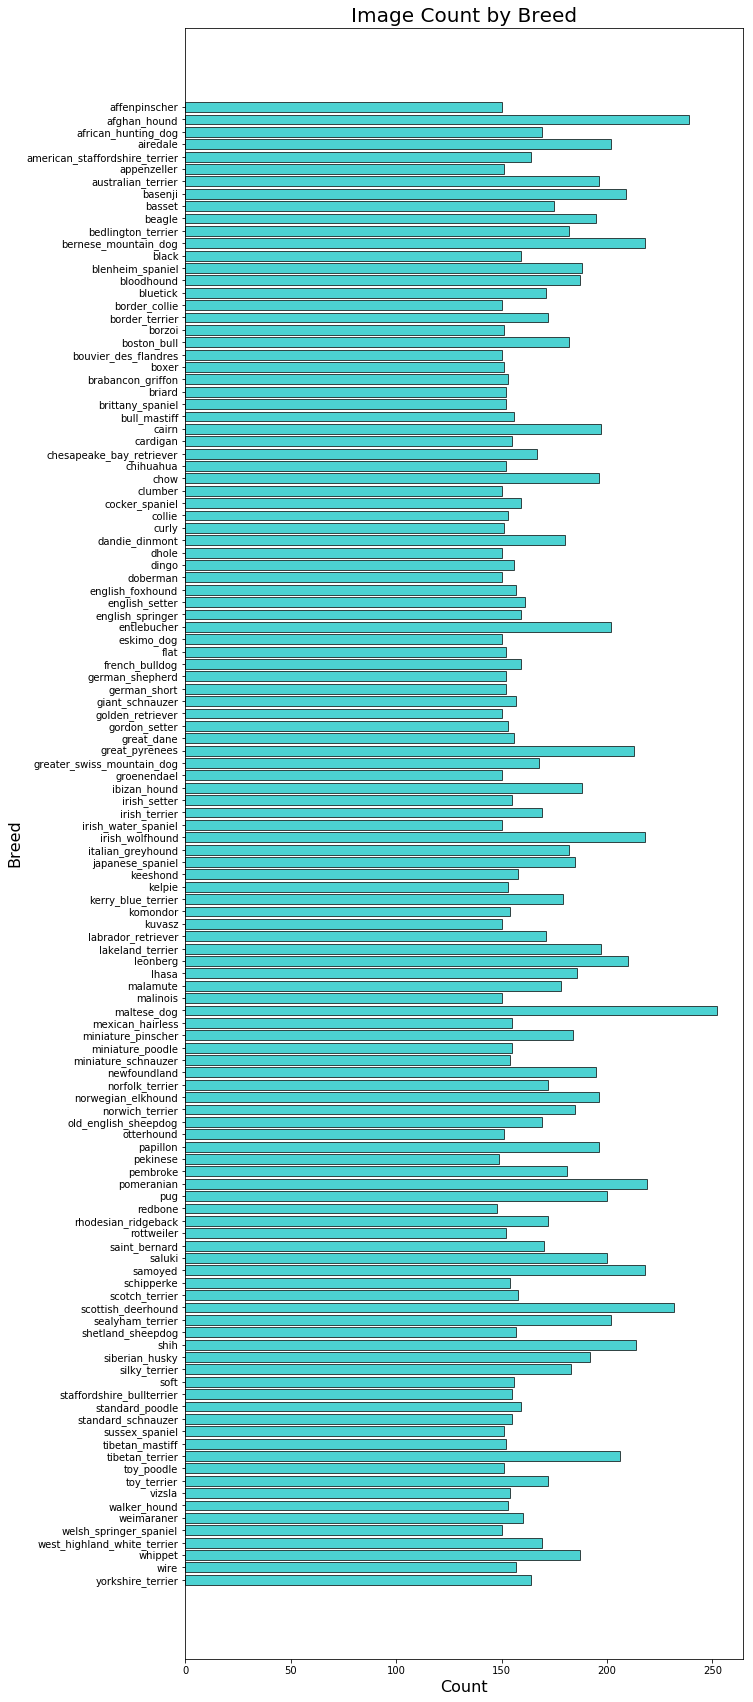

In [7]:
#plot the image count by breed 
fig, ax = plt.subplots(1,1,figsize=(10,30));
ax.barh(br_df.index.values,br_df['count'],alpha=0.7,color='c',edgecolor='k');
plt.title("Image Count by Breed",fontsize = title_fs)
plt.xlabel("Count",fontsize = label_fs)
plt.ylabel("Breed",fontsize = label_fs)
plt.gca().invert_yaxis()
plt.show();

In [8]:
#create a function to extract the data for each annotation file (xml format)
def get_annotation_info(path):
    xml_root = xml.etree.ElementTree.parse(path).getroot()
    obj = xml_root.findall('object')[0]
    name = obj.findall('name')[0].text.lower()
    bound_box = obj.findall('bndbox')[0]
    pose = obj.findall('pose')[0].text.lower()
    trunc = obj.findall('truncated')[0].text.lower()
    diff = obj.findall('difficult')[0].text.lower()
    seg = xml_root.findall('segment')[0].text.lower()

    return name,bound_box.findall('xmin')[0],bound_box.findall('ymin')[0],bound_box.findall('xmax')[0],bound_box.findall('ymax')[0],pose,trunc,diff,seg 

In [9]:
#process through each annotation using the function above
breed = []
x_min = []
y_min = []
x_max = []
y_max = []
pose = []
truncated = []
difficult = []
segment = []

for i in range(len(file_list_name)):
    folder = file_list_name[i].split('/')[0]
    file = file_list_name[i].split('/')[1].split('.')[0]
    annotation_path = 'Annotation/' + folder + '/' + file
    name,xmin,ymin,xmax,ymax,dog_pose,trunc,diff,seg = get_annotation_info(annotation_path)
    breed.append(name)
    x_min.append(xmin.text)
    y_min.append(ymin.text)
    x_max.append(xmax.text)
    y_max.append(ymax.text)
    pose.append(dog_pose)
    truncated.append(trunc)
    difficult.append(diff)
    segment.append(seg)
height = [int(y_max[i])-int(y_min[i]) for i in range(len(y_max))]
width = [int(x_max[i])-int(x_min[i]) for i in range(len(x_max))]

size = [height[i]*width[i] for i in range(len(height))] 

In [10]:
#create a data frame of the annotation info
breed_annotate_size = pd.DataFrame({'breed':breed,
                                    'x_min':x_min,
                                    'x_max':x_max,
                                    'y_min':y_min,
                                    'y_max':y_max,
                                    'pose':pose,
                                    'truncated':truncated,
                                    'difficult':difficult,
                                    'segment':segment,
                                    'height':height,
                                    'width':width,
                                    'size':size})

In [11]:
breed_annotate_size.head(25)

,breed,x_min,x_max,y_min,y_max,pose,truncated,difficult,segment,height,width,size
0,chihuahua,25,276,10,498,unspecified,0,0,0,488,251,122488
1,chihuahua,49,393,9,493,unspecified,0,0,0,484,344,166496
2,chihuahua,142,335,43,250,unspecified,0,0,0,207,193,39951
3,chihuahua,0,312,27,498,unspecified,0,0,0,471,312,146952
4,chihuahua,90,242,104,452,unspecified,0,0,0,348,152,52896
5,chihuahua,17,451,38,253,unspecified,0,0,0,215,434,93310
6,chihuahua,39,145,191,383,unspecified,0,0,0,192,106,20352
7,chihuahua,76,363,30,375,unspecified,0,0,0,345,287,99015
8,chihuahua,59,229,37,179,unspecified,0,0,0,142,170,24140
9,chihuahua,317,558,95,459,unspecified,0,0,0,364,241,87724


In [12]:
#no variation in difficult annotation value
breed_annotate_size.groupby('difficult').count()

,breed,x_min,x_max,y_min,y_max,pose,truncated,segment,height,width,size
difficult,,,,,,,,,,,
0,20580,20580,20580,20580,20580,20580,20580,20580,20580,20580,20580


In [13]:
#no variation in truncated annotation value
breed_annotate_size.groupby('truncated').count()

,breed,x_min,x_max,y_min,y_max,pose,difficult,segment,height,width,size
truncated,,,,,,,,,,,
0,20580,20580,20580,20580,20580,20580,20580,20580,20580,20580,20580


In [14]:
#no variation in segment annotation value
breed_annotate_size.groupby('segment').count()

,breed,x_min,x_max,y_min,y_max,pose,truncated,difficult,height,width,size
segment,,,,,,,,,,,
0,20580,20580,20580,20580,20580,20580,20580,20580,20580,20580,20580


In [15]:
#no variation in pose annotation value
breed_annotate_size.groupby('pose').count()

,breed,x_min,x_max,y_min,y_max,truncated,difficult,segment,height,width,size
pose,,,,,,,,,,,
null,624,624,624,624,624,624,624,624,624,624,624
unspecified,19956,19956,19956,19956,19956,19956,19956,19956,19956,19956,19956


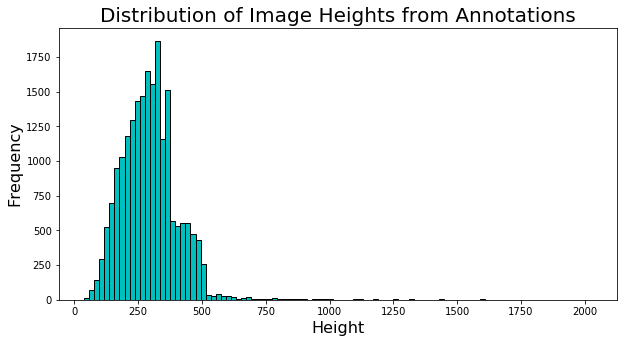

In [16]:
#plot histograph of image heights
plt.figure(figsize=(10,5))
plt.hist(height,bins=100,color='c',edgecolor='k')
plt.title("Distribution of Image Heights from Annotations",fontsize = title_fs)
plt.xlabel("Height",fontsize = label_fs)
plt.ylabel("Frequency",fontsize = label_fs)
plt.show() 

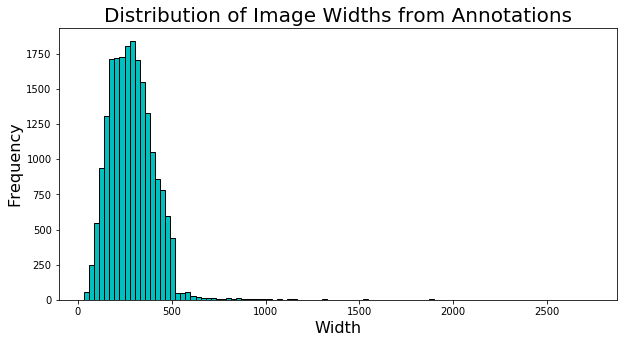

In [17]:
#plot histograph of image widths
plt.figure(figsize=(10,5))
plt.hist(width,bins=100,color='c',edgecolor='k')
plt.title("Distribution of Image Widths from Annotations",fontsize = title_fs)
plt.xlabel("Width",fontsize = label_fs)
plt.ylabel("Frequency",fontsize = label_fs)
plt.show() 

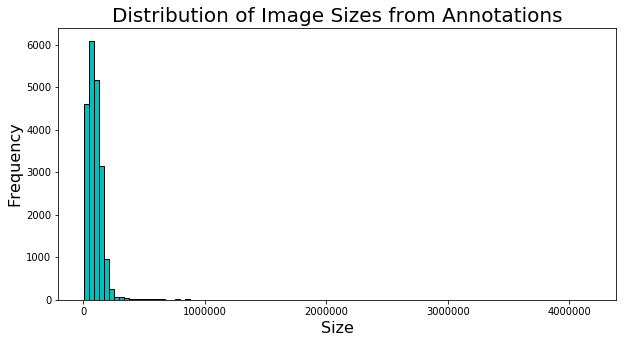

In [18]:
#plot histograph of image sizes
plt.figure(figsize=(10,5))
plt.hist(size,bins=100,color='c',edgecolor='k')
plt.title("Distribution of Image Sizes from Annotations",fontsize = title_fs)
plt.xlabel("Size",fontsize = label_fs)
plt.ylabel("Frequency",fontsize = label_fs)
plt.show() 

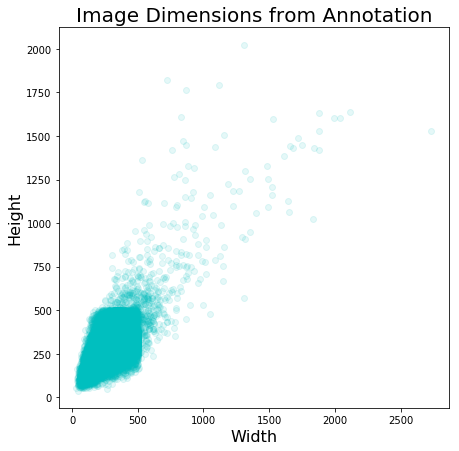

In [19]:
#plot height vs. width of images
plt.figure(figsize=(7,7))
plt.plot(width,height,'o', alpha = .1, color='c')
plt.title("Image Dimensions from Annotation",fontsize = title_fs)
plt.xlabel("Width",fontsize = label_fs)
plt.ylabel("Height",fontsize = label_fs)
plt.show()

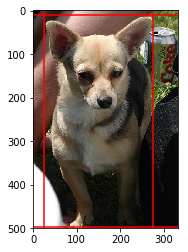

In [20]:
#plot of image with boundary box
img_num = 0
img_folder = file_list_name[img_num].split('/')[0]
img_file = file_list_name[img_num].split('/')[1].split('.')[0]
img_path = 'Images/' + img_folder + '/' + img_file + '.jpg'

img = plt.imshow(plt.imread(img_path));

plt.axhline(int(breed_annotate_size['y_min'][img_num]),color='red');
plt.axhline(int(breed_annotate_size['y_max'][img_num]),color='red');
plt.axvline(int(breed_annotate_size['x_min'][img_num]),color='red');
plt.axvline(int(breed_annotate_size['x_max'][img_num]),color='red');

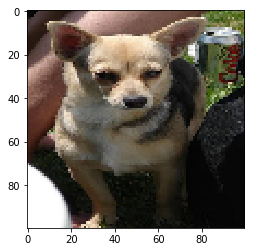

In [21]:
#example of the effect if we resize the images to a standard square size 
resized_img = plt.imshow(skimage.transform.resize(plt.imread(img_path),(100,100),mode='constant'))

In [235]:
#unbound (not cropped to annotation suggestions) - test
y_test_ub = []
x_test_ub = []

for i in range(len(file_list_name_test)):
    file = file_list_name_test[i]
    if file.split('/')[0].split('-')[1].lower() in ('chihuahua','maltese_dog','japanese_spaniel'):
        img_folder = file.split('/')[0]
        img_file = file.split('/')[1].split('.')[0]
        img_path = 'Images/' + img_folder + '/' + img_file + '.jpg'

        y_min = int(breed_annotate_size['y_min'][i])
        y_max = int(breed_annotate_size['y_max'][i])
        x_min = int(breed_annotate_size['x_min'][i])
        x_max = int(breed_annotate_size['x_max'][i])

        img_pre = plt.imread(img_path)[x_min:x_max,y_min:y_max]
        if img_pre.shape[1]>0 and img_pre.shape[0] > 0:
            img = skimage.transform.resize(img_pre,(250,250),mode='constant')
            x_test_ub.append(img)
            y_test_ub.append(file.split('/')[0].split('-')[1].lower())

    

In [234]:
#unbound (not cropped to annotation suggestions) - train

y_train_ub = []
x_train_ub = []

for i in range(len(file_list_name_train)):
    file = file_list_name_train[i]
    if file.split('/')[0].split('-')[1].lower() in ('chihuahua','maltese_dog','japanese_spaniel'):
        img_folder = file.split('/')[0]
        img_file = file.split('/')[1].split('.')[0]
        img_path = 'Images/' + img_folder + '/' + img_file + '.jpg'

        y_min = int(breed_annotate_size['y_min'][i])
        y_max = int(breed_annotate_size['y_max'][i])
        x_min = int(breed_annotate_size['x_min'][i])
        x_max = int(breed_annotate_size['x_max'][i])

        img_pre = plt.imread(img_path)[x_min:x_max,y_min:y_max]
        if img_pre.shape[1]>0 and img_pre.shape[0] > 0:
            img = skimage.transform.resize(img_pre,(250,250),mode='constant')
            x_train_ub.append(img)
            y_train_ub.append(file.split('/')[0].split('-')[1].lower())

In [233]:
#bound (cropped to annotation suggestions) - test
y_test = []
x_test = []

for i in range(len(file_list_name_test)):
    file = file_list_name_test[i]
    if file.split('/')[0].split('-')[1].lower() in ('chihuahua','maltese_dog','japanese_spaniel'):
        img_folder = file.split('/')[0]
        img_file = file.split('/')[1].split('.')[0]
        img_path = 'Images/' + img_folder + '/' + img_file + '.jpg'

        y_min = int(breed_annotate_size['y_min'][i])
        y_max = int(breed_annotate_size['y_max'][i])
        x_min = int(breed_annotate_size['x_min'][i])
        x_max = int(breed_annotate_size['x_max'][i])

        img_pre = plt.imread(img_path)[x_min:x_max,y_min:y_max]
        if img_pre.shape[1]>0 and img_pre.shape[0] > 0:
            img = skimage.transform.resize(img_pre,(250,250),mode='constant')
            x_test.append(img)
            y_test.append(file.split('/')[0].split('-')[1].lower())

    

In [231]:
#bound (cropped to annotation suggestions) - train
y_train = []
x_train = []

for i in range(len(file_list_name_train)):
    file = file_list_name_train[i]
    if file.split('/')[0].split('-')[1].lower() in ('chihuahua','maltese_dog','japanese_spaniel'):
        img_folder = file.split('/')[0]
        img_file = file.split('/')[1].split('.')[0]
        img_path = 'Images/' + img_folder + '/' + img_file + '.jpg'

        y_min = int(breed_annotate_size['y_min'][i])
        y_max = int(breed_annotate_size['y_max'][i])
        x_min = int(breed_annotate_size['x_min'][i])
        x_max = int(breed_annotate_size['x_max'][i])

        img_pre = plt.imread(img_path)[x_min:x_max,y_min:y_max]
        if img_pre.shape[1]>0 and img_pre.shape[0] > 0:
            img = skimage.transform.resize(img_pre,(250,250),mode='constant')
            x_train.append(img)
            y_train.append(file.split('/')[0].split('-')[1].lower())

In [236]:
#convert lists to arrays to be able ot put them in keras
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)
x_train_ub = np.asarray(x_train_ub)
x_test_ub = np.asarray(x_test_ub)

In [237]:
#sloppily make categorical
y_train2 = []
y_train2_ub = []

for i in range(len(y_train)):
    if y_train[i] == 'chihuahua':
        y = 0
    elif y_train[i] == 'japanese_spaniel':
        y = 1
    else:
        y = 2
    y_train2.append(y)
    y_train2_ub.append(y)

In [240]:
y_test2 = []
y_test2_ub = []
for i in range(len(y_test)):
    if y_test[i] == 'chihuahua':
        y = 0
    elif y_test[i] == 'japanese_spaniel':
        y = 1
    else:
        y = 2
    y_test2.append(y)
    y_test2_ub.append(y)

In [241]:
y_test = np.asarray(y_test2)
y_train = np.asarray(y_train2)
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)


y_test_ub = np.asarray(y_test2_ub)
y_train_ub = np.asarray(y_train2_ub)
y_train_ub = keras.utils.to_categorical(y_train_ub)
y_test_ub = keras.utils.to_categorical(y_test_ub)
y_train

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

In [242]:

model1 = Sequential()

model1.add(Conv2D(16, (3, 3), activation = "relu", input_shape=(250, 250, 3)))
model1.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4)))
model1.add(Dropout(0.2))

model1.add(Conv2D(32, (3, 3), activation = 'relu'))
model1.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4)))
model1.add(Dropout(0.2))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4)))
model1.add(Dropout(0.2))

model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(Flatten())
model1.add(Dropout(0.2))

model1.add(Dense(512, activation='relu'))
model1.add(Dense(3, activation='softmax'))
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 248, 248, 16)      448       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 13, 13, 64)        18496     
__________

In [245]:
#run on unbounded
EPOCHS = 4
model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
#checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
 #                              verbose=1, save_best_only=True)
model1.fit(x_train_ub, y_train_ub,epochs=EPOCHS, batch_size=32, verbose=1,validation_split = .2,shuffle=True)

Train on 234 samples, validate on 59 samples
Epoch 1/4
234/234 [==============================] - 13s 56ms/step - loss: 1.1963 - acc: 0.5427 - val_loss: 1.6400 - val_acc: 0.0000e+00
Epoch 2/4
234/234 [==============================] - 12s 50ms/step - loss: 0.9957 - acc: 0.5684 - val_loss: 1.4335 - val_acc: 0.0000e+00
Epoch 3/4
234/234 [==============================] - 13s 55ms/step - loss: 0.9567 - acc: 0.5897 - val_loss: 1.3377 - val_acc: 0.0000e+00
Epoch 4/4
234/234 [==============================] - 13s 54ms/step - loss: 0.9472 - acc: 0.5855 - val_loss: 1.4197 - val_acc: 0.0000e+00


In [246]:
#run on bounded
EPOCHS = 4
model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
#checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
 #                              verbose=1, save_best_only=True)
model1.fit(x_train, y_train,epochs=EPOCHS, batch_size=32, verbose=1,validation_split = .2,shuffle=True)

Train on 234 samples, validate on 59 samples
Epoch 1/4
234/234 [==============================] - 14s 58ms/step - loss: 1.1704 - acc: 0.5171 - val_loss: 1.4669 - val_acc: 0.0000e+00
Epoch 2/4
234/234 [==============================] - 12s 53ms/step - loss: 0.8952 - acc: 0.5812 - val_loss: 1.5343 - val_acc: 0.0000e+00
Epoch 3/4
234/234 [==============================] - 13s 54ms/step - loss: 0.8946 - acc: 0.5855 - val_loss: 1.5584 - val_acc: 0.0000e+00
Epoch 4/4
234/234 [==============================] - 13s 55ms/step - loss: 0.8787 - acc: 0.5940 - val_loss: 1.5473 - val_acc: 0.0000e+00
